In [1]:
#cd("~/Projects/ASTRAL/soundings/src/")

# activate the environment
# an environment is just a path with Manifest.toml and Project.toml
using Pkg; Pkg.activate("..")

using Revise
# using RegularExpressions # Regexs natively loaded in julia
using CSV, DataFrames
using Interpolations
using Dates
using PyPlot

  Activating project at `~/Projects/ASTRAL/soundings`


In [28]:
# thermodynamics of water functions

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K

Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = 2.501e6 + (Cpv-Cw) * (TempK-273.0)

"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5; P=p*1e-2)
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

# supply TK [Kelvin] by keyword, ignores positional T!!
function es(T,p=1e5; TK=T+C, P=p*1e-2)
    T = TK - C
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"""
qs(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qs [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function qs(p,T)
    esat = es(T,p)
    qsat = RdoRv*esat / (p + (RdoRv-1)*esat)
end

"dqsdT(p,T[C]) derivative of qs with respect to T at p,T by autodiff of Bolton's qs"
dqsdT(p,T) = ForwardDiff.derivative(t -> qs(p,t), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qs(pa, Ta)
# Twet_autodiff(Ta, rh*qs(pa, Ta-C), pa) 

Twet_autodiff

In [2]:
# path on fog
# datapath = "/Users/sdeszoek/Library/CloudStorage/OneDrive-SharedLibraries-OregonStateUniversity/og_ekamsat-st - Documents/RR2306/RR2306_Science_Share/Radiosondes"
# path on squall
datapath = "/Users/sdeszoek/Library/CloudStorage/OneDrive-SharedLibraries-UW/og_ekamsat-st - Documents/RR2306/RR2306_Science_Share/Radiosondes"
raobe_file(dt) = joinpath(datapath, "RAOBE" * Dates.format(dt, "yyyymmddHH") * ".csv")
raobe_file(DateTime(2023,6,17,0,0,0))

raobe_files = filter(startswith("RAOBE"), readdir(datapath))
xtrct_datestamp(f) = f[6:15]  # brittle
raobe_dt = DateTime(xtrct_datestamp(raobe_files[1]), "yyyymmddHH")
typeof(raobe_dt)

DateTime

In [18]:
"single-character replacer handles tabs and \u00b0 degree character °"
stripjunk(f) = f # IOBuffer(replace(read(f), UInt8('\t') => UInt8(' '), UInt16('\u00b0') => UInt8('d')) )

"false->-1, true->1"
signer(bool) = 2(0+bool)-1

"read the file and return (DataFrame, lat, lon)"
function read_raobe( file )
    open( file, "r" ) do io
        lat = 0
        lon = 0
        # read header lines and parse lat,lon
        ln = readline( io )
        while match(r"RAOB/DATA", ln) === nothing
            if startswith(ln, "LAT")
                mtc = match(r"LAT,([\d.]*),([NS])", ln)
                lat += parse(Float32, mtc[1]) * signer(mtc[2]=="N")
                show("lat=$(lat)")
            elseif startswith(ln, "LON")
                mtc = match(r"LON,([\d.]*),([EW])", ln)
                lon += parse(Float32, mtc[1]) * signer(mtc[2]=="E")
            end
            ln = readline( io )
        end
        # "PRES,TEMP,RH,WIND,SPEED,GPM"
        CSV.read( stripjunk( io ),
            DataFrame, delim=",", stripwhitespace=true, ignorerepeated=true ), lat, lon
    end
end

df, lat, lon =  read_raobe(joinpath(datapath, raobe_files[1]))

"lat=12.057"

(2154×6 DataFrame
  Row │ PRES     TEMP     RH     WIND   SPEED    GPM   
      │ Float64  Float64  Int64  Int64  Float64  Int64 
──────┼────────────────────────────────────────────────
    1 │  1008.4     23.7     43    357      8.7     20
    2 │  1007.3     27.0     47    264      6.2     30
    3 │  1006.2     28.8     52    238     11.1     40
    4 │  1005.0     28.6     61    238     11.4     50
    5 │  1003.9     28.5     71    239     11.5     60
    6 │  1002.8     28.5     76    239     11.5     70
    7 │  1001.6     28.3     76    239     11.5     80
    8 │  1000.5     28.2     76    239     11.7     90
  ⋮   │    ⋮        ⋮       ⋮      ⋮       ⋮       ⋮
 2148 │    44.3    -60.8      1    129      5.8  21490
 2149 │    44.2    -60.8      2    132      5.8  21500
 2150 │    44.1    -60.9      2    135      5.9  21510
 2151 │    44.1    -60.8      2    138      5.9  21520
 2152 │    44.0    -60.8      3    141      6.1  21530
 2153 │    43.9    -60.8      1    145      6.

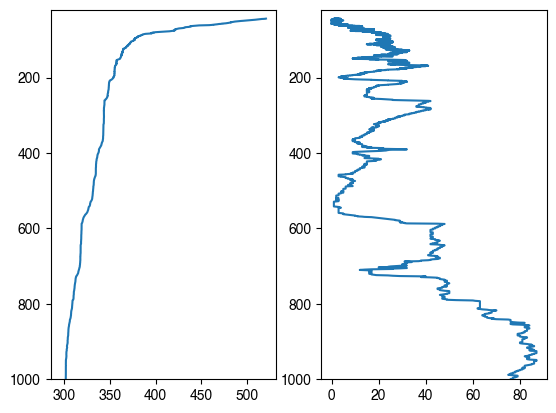

In [27]:
# thermo functions

"Exner function = T/θ = (p/p0)^(Rd/Cp)"
Exner(p) = (p/1000)^0.287

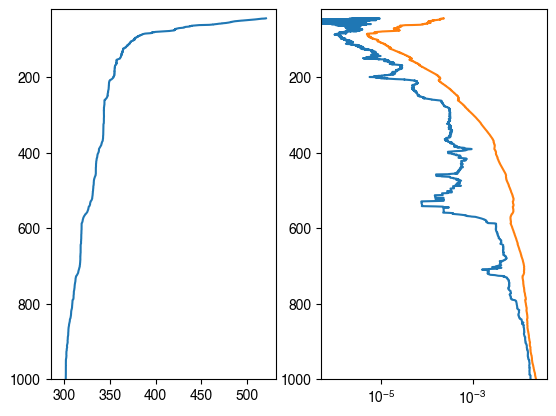

In [32]:
# plot example sounding
qs_ = @. qs(1e2*df[!,:PRES], df[!,:TEMP])
qv = @. qs_ * df[!,:RH]/1e2
theta_ = @. (df[!,:TEMP]+C) / Exner(df[!,:PRES])

clf()
subplot(1,2,1)
plot(theta_, df[!,:PRES])
ylim([1000, 20])

subplot(1,2,2)
# plot(df[!,:RH], df[!,:PRES])
semilogx(qv, df[!,:PRES])
plot(qs_, df[!,:PRES])
ylim([1000, 20])
gcf()

In [25]:
# test that the file names are readable for all stations

for stationdir in lowercase.(CamelStations) # e.g., lowercase("Visakhapatnam")
    
    # read standard named files in the station's directory
    soundingfiles(stationdir; reldatapath=reldatapath) = filter(x -> occursin(r"(?i)(May|Standard_Summary|Standard-Summary|Standard Summary).*(\.txt)$(?-i)",x),
                   readdir(joinpath(reldatapath, stationdir)) ) 
    files = soundingfiles( stationdir ) 
    
    # remove duplicate times uniqueidx(v) = unique(i -> v[i], eachindex(v))
    uniqueidx(v) = unique(i -> v[i], eachindex(v))
    #=
    @show stationdir
    @show files
    =#
    
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    collect(zip(fdt[ui[ord]], files[ui[ord]]))
end

In [26]:
# Interpolation methods
# Pressure is irregular and different for each sounding time.

"dv converts Datetimes to numeric values for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Filter missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind]) # .& .!ismissing.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"rectangular interval averaging onto a decreasing pressure coordinate"
function pavg(x::Vector, p::Vector; plevs=1020.0:-5.0:0.0)
    s1 = zeros(Float64, size(plevs))
    # s2 = zeros(Float64, size(p))
    ns = zeros(Float64, size(plevs))
    
    for i in eachindex(p)
        j = findfirst(x -> x < p[i], plevs) # j indexes plevs
        s1[j] += isfinite(x[i]) ? x[i] : 0
        # s2[j] += x[i]^2
        ns[j] += 1.0*isfinite(x[i])
    end
    
    s1 ./ ns # mean
end

# pressure levels to interploate to
dp = 5.0
plevs = 1020.0:-dp:0.0

# test interpolation inline: plot( itp(u) )
#=
if !isempty(df)
    upi = uniqueidx(p)
    plot(plevs, m2n.(itp(u[upi], p[upi])[plevs]))
    # test averaging
    # plot(plevs, pavg(u, p plevs=plevs))
    
    plot(m2n.(p), m2n.(wspd))
    u_pl = pavg(u, p, plevs=plevs)
    # plev is the level geometrically above and dynamically (pressure) below the binned observations
    # probably suitable for pcolormesh
    plot(plevs.+dp/2, u_pl)
end
=#

1020.0:-5.0:0.0

In [27]:
# 1 file example

station = lowercase("Chennai") # Ahmedabad #2 is MISDA DUE TO SIGNAL FAILED
files = soundingfiles(station)
#filter(x -> occursin(r"(?i)(May|Standard).*(\.txt)$(?-i)",x), readdir(joinpath(reldatapath, station) ))

# dt = imd_file_date(files[ui[ord[8]]])

# deduplicate sounding times
fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order

# reader functions


"number of headerlines" # no longer needed
function hdrs( station, file )
    # these visakhapatnam files have fewer headerlines
    bollox = ["43150-20230527-00-Standard-Summary.txt",
              ] # have 3 headerlines
    alpharng = ["43150-20230605-00-Standard-Summary.txt", "43150-20230609-00-Standard-Summary.txt"] # files later than this have 3 headerlines
    (station=="visakhapatnam" && file<alpha && !(file in bollox) ) ? 7 : 3
end

"single-character replacer handles tabs and \u00b0 degree character °"
stripjunk(f) = IOBuffer(replace(read(f), UInt8('\t') => UInt8(' '), UInt16('\u00b0') => UInt8('d')) )

"read the file and return a DataFrame"
# function read_sonde( station, file; header=hdrs(station,file) )
function read_sonde( file )
    open( file, "r" ) do io
        # skip header by reading up through a blank line
        hdln = readline( io )
        while !isempty(hdln)
            hdln = readline( io )
        end
        CSV.read( stripjunk( io ),
            DataFrame, delim=",", stripwhitespace=true, ignorerepeated=true ) # header=header
    end
end

# test read
@show joinpath(reldatapath, station, files[ui[ord[2]]])
df = read_sonde( joinpath(reldatapath, station, files[ui[ord[2]]]) )
df

joinpath(reldatapath, station, files[ui[ord[2]]]) = "../data/EKAMSAT_IMD/ekamsat/chennai/02May23MayChennai.txt"


Row,Time,p(hPa),T(dC),U(%),Dew(dC),Geo(gpm),Geo(gpft),Wdir(d),Wspd(m/s),Asc(m/m),Avg Asc(m/m),Azimuth(d),Range(m),Elevation(d)
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,000.00:00,1006.3,24.2,98.0,23.8,15.0,49.1,135.0,4.0,81.4,81.4,37.4,12758.6,0.1
2,000.01:00,1005.8,24.2,98.9,24.0,19.7,64.5,199.2,5.6,86.1,83.7,37.4,12764.4,0.1
3,000.02:00,1005.3,24.1,98.9,23.9,24.0,78.9,201.4,5.6,90.6,86.0,37.4,12769.7,0.1
4,000.03:00,1004.8,24.2,99.1,24.1,28.3,93.0,202.2,5.8,94.9,88.2,37.4,12775.1,0.1
5,000.04:00,1004.3,24.3,98.9,24.1,32.4,106.4,202.5,6.0,98.9,90.4,37.4,12780.8,0.1
6,000.05:00,1003.9,24.4,99.1,24.3,36.2,118.8,200.9,6.3,103.4,92.5,37.4,12786.8,0.2
7,000.06:00,1003.4,24.6,99.1,24.4,40.2,131.9,200.3,6.3,107.5,94.7,37.3,12792.1,0.2
8,000.07:00,1003.0,24.8,99.3,24.6,44.2,145.0,200.6,6.3,112.1,96.9,37.3,12796.8,0.2
9,000.08:00,1002.6,24.8,99.3,24.7,47.8,156.8,201.0,6.3,115.8,99.0,37.3,12801.5,0.2


# Column headers 

Chennai, Karaikal, Kochi, Kolkata, Ahmedabad, Pune
```
Time,     p(hPa),    T(?C),    U(%),      Dew(?C),     Geo(gpm),   Geo(gpft),    Wdir(?),    Wspd(m/s),    Asc(m/m),    Avg Asc(m/m),    Azimuth(?),   Range(m),    Elevation(?),
```
Mangalore, PortBlair
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
Visakhapatnam
43150-20230512-00-Standard-Summary.txt, 43150-20230520-00-Standard-Summary.txt: 3 headerlines
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
all other Visakhapatnam: 7 headerlines

Simon edited the 2 Vsk files to make them have 7

In [28]:
NamePatterns = [ 
    ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"], #Visakhapatnam style 1
    ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"] # Mangalore, Visakhapatnam
    ]

2-element Vector{Vector{String}}:
 ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"]
 ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"]

In [29]:
# test read a sounding

p, T,Td, rh,z, wspd,wdir, u,v = get_sounding_cols(df, station)

#=
# test plot
clf()
plot( m2n.(T), m2n.(p), label="Temperature (C)")
ylim(1000, 20)
station
=#

([1006.3, 1005.8, 1005.3, 1004.8, 1004.3, 1003.9, 1003.4, 1003.0, 1002.6, 1002.2  …  92.9, 92.8, 92.8, 92.7, 92.7, 92.7, 92.6, 92.6, 92.5, 92.5], [24.2, 24.2, 24.1, 24.2, 24.3, 24.4, 24.6, 24.8, 24.8, 25.0  …  -83.1, -83.2, -83.2, -83.3, -83.2, -83.2, -83.1, -83.1, -83.0, -83.0], [23.8, 24.0, 23.9, 24.1, 24.1, 24.3, 24.4, 24.6, 24.7, 24.9  …  -90.4, -90.5, -90.6, -90.6, -90.6, -90.5, -90.5, -90.4, -90.4, -90.4], [98.0, 98.9, 98.9, 99.1, 98.9, 99.1, 99.1, 99.3, 99.3, 99.1  …  27.5, 27.5, 27.5, 27.5, 27.5, 27.5, 27.5, 27.5, 27.7, 27.7], [15.0, 19.7, 24.0, 28.3, 32.4, 36.2, 40.2, 44.2, 47.8, 50.7  …  16985.3, 16988.1, 16990.8, 16993.6, 16996.3, 16998.5, 17001.1, 17004.0, 17006.5, 17008.9], [4.0, 5.6, 5.6, 5.8, 6.0, 6.3, 6.3, 6.3, 6.3, 6.4  …  15.2, 14.9, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.4, 15.5], [135.0, 199.2, 201.4, 202.2, 202.5, 200.9, 200.3, 200.6, 201.0, 201.8  …  115.4, 115.2, 114.9, 114.8, 114.9, 115.0, 114.9, 114.7, 114.4, 114.3], [-2.8284271247461903, 1.8416532217360653, 2.

In [59]:
"extract column data by name"
function get_sounding_cols(df, station)
    if isempty(df)
        # p = [missing]
        # T = [missing]
        # Td = [missing]
        # rh= [missing]
        # z = [missing]
        # wspd = [missing]
        # wdir = [missing]
        p = []
        T = []
        Td = []
        rh= []
        z = []
        wspd = []
        wdir = []
    else
        if in(station, ["mangalore", "visakhapatnam", "portblair"])
            if "P(hPa)" in names(df)
                p = df[!,"P(hPa)"][:]
                T = df[!,"T(C)"][:]
                Td = df[!,"Dew(C)"][:]
                rh = df[!,"U(%)"][:]
                z = df[!,"Geo(gpm)"][:]
                wspd = df[!,"Wspd(m/s)"][:]
                wdir = df[!,"Wdir(d)"][:]
            elseif "p(hPa)" in names(df) # slightly different keys
                p = df[!,"p(hPa)"][:]
                rh = df[!,"U(%)"][:]
                z = df[!,"Geo(gpm)"][:]
                wspd = df[!,"Wspd(m/s)"][:]
                if "T(dC)" in names(df)
                    T = df[!,"T(dC)"][:]
                    Td = df[!,"Dew(dC)"][:]
                    wdir = df[!,"Wdir(d)"][:]
                elseif "T(Deg.C)" in names(df) # another variation
                    T = df[!,"T(Deg.C)"][:]
                    Td = df[!,"Dew(Deg.C)"][:]
                    wdir = df[!,"Wdir(Deg)"][:]
                end
            end
        else # slightly different keys
            p = df[!,"p(hPa)"][:]
            rh = df[!,"U(%)"][:]
            z = df[!,"Geo(gpm)"][:]
            wspd = df[!,"Wspd(m/s)"][:]
            if "T(dC)" in names(df)
                T = df[!,"T(dC)"][:]
                Td = df[!,"Dew(dC)"][:]
                wdir = df[!,"Wdir(d)"][:]
            elseif "T(Deg.C)" in names(df) # another variation
                T = df[!,"T(Deg.C)"][:]
                Td = df[!,"Dew(Deg.C)"][:]
                wdir = df[!,"Wdir(Deg)"][:]
            end

        end
    end
    u = -wspd .* sin.(pi/180.0*wdir)
    v = -wspd .* cos.(pi/180.0*wdir)
    
    return p, T,Td, rh,z, wspd,wdir, u,v
end

get_sounding_cols

In [31]:
# sounding variable functions

meanfinite(x, dims) = sum(isfinite(x) ? x : 0, dims=dims)./sum(isfinite, x, dims=dims)
anom(x; dims=ndims(x)) = x .- meanfinite(x, dims)

"Exner function T/θ = (p/p_0)^Rd/cp"
Exner(p) = (p/1000.0)^0.287 # = T/theta
th(T,p) = T/Exner(p)

# put NaNs in for missing for matplotlib
m2n(x) = ismissing(x) ? NaN : x

m2n (generic function with 1 method)

In [32]:
# inventory files, times
station="visakhapatnam" # "visakhapatnam"
    # read standard named files in the station's directory
    files = soundingfiles(station)
    # deduplicate sounding times
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    cat(files[ui[ord]], fdt[ui[ord]], dims=2)


# test read visakhapatanm
for ti in ui[ord]
    fn = joinpath(reldatapath, station, files[ti])
    df = read_sonde( joinpath(reldatapath, station, files[ti]) )
    @show files[ti]
    if !isempty(df)
        # extract ungridded hi-res data
        p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
    end
end

files[ti] = "01MAY2023VSK.txt"
files[ti] = "02MAY2023VSK.txt"
files[ti] = "03MAY2023VSK.txt"
files[ti] = "04MAY2023VSK.txt"
files[ti] = "05MAY2023VSK.txt"
files[ti] = "06MAY2023VSK.txt"
files[ti] = "07MAY2023VSK.txt"
files[ti] = "08MAY2023VSK.txt"
files[ti] = "09MAY2023VSK.txt"
files[ti] = "10MAY2023VSK.txt"
files[ti] = "43150-20230511-00-Standard-Summary.txt"
files[ti] = "43150-20230512-00-Standard-Summary.txt"
files[ti] = "43150-20230513-00-Standard-Summary.txt"
files[ti] = "43150-20230514-00-Standard-Summary.txt"
files[ti] = "43150-20230515-00-Standard-Summary.txt"
files[ti] = "43150-20230516-00-Standard-Summary.txt"
files[ti] = "43150-20230517-00-Standard-Summary.txt"
files[ti] = "43150-20230518-00-Standard-Summary.txt"
files[ti] = "43150-20230519-00-Standard-Summary.txt"
files[ti] = "43150-20230520-00-Standard-Summary.txt"
files[ti] = "43150-20230521-00-Standard-Summary.txt"
files[ti] = "43150-20230522-00-Standard-Summary.txt"
files[ti] = "43150-20230523-00-Standard-Summary.txt"
f

In [33]:
# start over and do a big loop to load and interpolate data to consistent levels

# lexical defaults for grid_imd_sondes
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-5.0:0.0
CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
stationnames = lowercase.(CamelStations)

#=
# allocate gridded data arrays (pressure, location, launch time)
# for grid_imd_soundings! to update in-place.
nt = count_max_unique_soundings(stationnames)
# nt = 80 # allow for longest station mangalore?(37), extend & trim off extra later
time = zeros(DateTime, length(stationnames), nt)
T  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
Td = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
rh = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
z  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
u  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
v  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
=#

"read and grid IMD soundings to pressure levels."
function grid_imd_soundings!( time, T, Td, rh, z, u, v; 
                              plevs=plevs, stationnames=stationnames, reldatapath=reldatapath )
    for (sj, station) in enumerate(stationnames)
        @show station
        # read standard named files in the station's directory
        files = soundingfiles(station)
        # sj += 1 # gridded station index
        # deduplicate sounding times
        fdt = imd_file_date.(files)
        fdt12 = round.(fdt, Dates.Hour(12))
        ui = uniqueidx(fdt12)
        fdt[ui] # exact datetimes with duplicates removed
        ord = sortperm(fdt[ui]) # guarantees ascending order
        #collect(zip( files[ui[ord]]], fdt[ui[ord]] ))
        
        tj = 0
        for ti in ui[ord]
            fn = joinpath(reldatapath, station, files[ti])
            df = read_sonde( joinpath(reldatapath, station, files[ti]) )
            if !isempty(df)
                # extract ungridded hi-res data
                p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
                # avg variables at the next time level
                tj += 1
                # update arrays in place
                time[sj,tj] = fdt[ti]
                T[  :, sj, tj] .= pavg(T_ , p_, plevs=plevs)
                Td[ :, sj, tj] .= pavg(Td_, p_, plevs=plevs)
                rh[ :, sj, tj] .= pavg(rh_, p_, plevs=plevs)
                z[  :, sj, tj] .= pavg(z_ , p_, plevs=plevs)
                u[  :, sj, tj] .= pavg(u_ , p_, plevs=plevs)
                v[  :, sj, tj] .= pavg(v_ , p_, plevs=plevs)
            else
                tj += 1
                time[sj,tj] =fdt[ti]
                # leave an empty sounding when missing
            end
        end
    end
    return # nothing
end

grid_imd_soundings!

In [55]:
# test, find corrupt files by hand

station = "ahmedabad"

files = soundingfiles(station)
# sj += 1 # gridded station index
# deduplicate sounding times
fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order
collect(zip( files[ui[ord]], fdt[ui[ord]] ))

tj = 0
ti = ui[ord[46]]
    fn = joinpath(reldatapath, station, files[ti])
    df = read_sonde( joinpath(reldatapath, station, files[ti]) )
    if !isempty(df)
        # extract ungridded hi-res data
        p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
        # avg variables at the next time level
        tj += 1
        # update arrays in place
        # time[sj,tj] = fdt[ti]
        # T[  :, sj, tj] .=
        pavg(T_ , p_, plevs=plevs)
        # Td[ :, sj, tj] .= pavg(Td_, p_, plevs=plevs)
        # rh[ :, sj, tj] .= pavg(rh_, p_, plevs=plevs)
        # z[  :, sj, tj] .= pavg(z_ , p_, plevs=plevs)
        # u[  :, sj, tj] .= pavg(u_ , p_, plevs=plevs)
        # v[  :, sj, tj] .= pavg(v_ , p_, plevs=plevs)
    else
        tj += 1
        # time[sj,tj] =fdt[ti]
        # leave an empty sounding when missing
    end

205-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
  31.05
  30.8875
  29.262500000000003
  28.72
  29.299999999999997
  26.9
  27.82666666666667
  27.52307692307692
   ⋮
 -66.79729729729728
 -66.20275229357797
 -66.33283582089555
 -64.50457516339866
 -58.730994152046776
 -53.014479638009114
 -52.02055335968386
 -47.48287461773701
 NaN
 NaN
 NaN
 NaN

In [56]:
# make time-height plot for each station

"sftp put file f to rendezvous.apl.washington.edu /incoming/sonde" # clunky, works
function put_file_apl( f )
    sftp_str = "sftp -P 2022 -i ~/.ssh/id_ed25519 sdeszoek@rendezvous.apl.washington.edu <<< 'put $(f) /incoming/sonde'"
    run(`sh -c $(sftp_str)`)
end

"output days from offset"
mpldate(timestamp, offset=DateTime(2023,4,30,0,0,0)) = Dates.value(timestamp-offset)/1000/60/60/24
#invmpldate( mlpd, offset=DateTime(2023,4,30,0,0,0) ) = mpldate+Dates.value(offset)/1000/60/60/24
mplday(d; offset=Date(2023,4,30)) = day(Day(d) + offset) # ticks

"Update plot all u,rh sounding timeheight profiles and put to APL."
function plot_timeheights( time, T, Td, rh, z, u, v )
    # count times at each station
    nts = sum(time.>DateTime(1000), dims=2)
    for sj in 1:9
        clf()
        subplot(2,1,1)
        pcolormesh( mpldate.(time[sj,1:nts[sj]]), plevs, u[:,sj,1:nts[sj]], vmin=-10, vmax=10, cmap=ColorMap("RdYlBu_r") )
        ylim(1000, 100)
        ylabel("u (m/s)")
        xtl,~ = xticks()
        xticks( xtl, mplday.(xtl,offset=Date(2023,4,30)) )
        colorbar()
        title(CamelStations[sj])
    
        subplot(2,1,2)
        pcolormesh( mpldate.(time[sj,1:nts[sj]]), plevs, rh[:,sj,1:nts[sj]], cmap=ColorMap("RdYlBu_r"))
        ylim(1000, 100)
        ylabel("RH (%)")
        xtl,~ = xticks()
        xticks( xtl, mplday.(xtl,offset=Date(2023,4,30)) )
        colorbar()
        xlabel(Dates.format(time[sj,1], "yyyy U"))
    
        figfile = "../plot/$(CamelStations[sj])_u_rh.svg"
        savefig( figfile )
        put_file_apl( figfile )
    end
end

plot_timeheights

In [57]:
"Write out pressure-gridded sonde data. Push new files to APL. Let old files stand."
function write_new_grid_sondes( time, T, Td, rh, z, u, v; stationnames )
    # count times at each station
    nts = sum(time.>DateTime(1000), dims=2)
    for (sj, station) in enumerate(stationnames)
        for tj in 1:nts[sj]
            fileout = joinpath("../data/EKAMSAT_IMD/grid_sondes/", Dates.format(time[sj,tj], "yyyymmdd-HH")*"_$(CamelStations[sj]).csv")
            if !isfile(fileout)
                # @show fileout
                dfo = DataFrame(  p=plevs,
                                  T=T[  :, sj, tj],
                                  Td=Td[:, sj, tj],
                                  rh=rh[:, sj, tj],
                                  z=z[  :, sj, tj],
                                  u=u[  :, sj, tj],
                                  v=v[  :, sj, tj]  )
                CSV.write( fileout, dfo )
                put_file_apl( fileout )
            end
        end
    end
end


write_new_grid_sondes

In [61]:
# test mangalore

# reiterate parameters for paths, names, and gridding
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-5.0:0.0
CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
stationnames = lowercase.(["mangalore"])

# allocate gridded data arrays (pressure, location, launch time)
nt = count_max_unique_soundings(stationnames)
# nt = 80 # allow for longest station mangalore?(37), extend & trim off extra later
times = zeros(DateTime, length(stationnames), nt)
T  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
Td = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
rh = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
z  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
u  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
v  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)

grid_imd_soundings!( times, T, Td, rh, z, u, v; plevs=plevs, stationnames=stationnames, reldatapath=reldatapath )

plot_timeheights( times, T, Td, rh, z, u, v )
write_new_grid_sondes( times, T, Td, rh, z, u, v; stationnames )

station = "mangalore"
sftp> put ../plot/Ahmedabad_u_rh.svg /incoming/sonde
Uploading ../plot/Ahmedabad_u_rh.svg to /incoming/sonde/Ahmedabad_u_rh.svg


Connected to rendezvous.apl.washington.edu.


LoadError: BoundsError: attempt to access 1×1 Matrix{Int64} at index [2]

station = "ahmedabad"
station = "chennai"
station = "karaikal"
station = "kochi"
station = "kolkata"
station = "mangalore"
station = "portblair"
station = "pune"
station = "visakhapatnam"
sftp> put ../plot/Ahmedabad_u_rh.svg /incoming/sonde
Uploading ../plot/Ahmedabad_u_rh.svg to /incoming/sonde/Ahmedabad_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Chennai_u_rh.svg /incoming/sonde
Uploading ../plot/Chennai_u_rh.svg to /incoming/sonde/Chennai_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Karaikal_u_rh.svg /incoming/sonde
Uploading ../plot/Karaikal_u_rh.svg to /incoming/sonde/Karaikal_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Kochi_u_rh.svg /incoming/sonde
Uploading ../plot/Kochi_u_rh.svg to /incoming/sonde/Kochi_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Kolkata_u_rh.svg /incoming/sonde
Uploading ../plot/Kolkata_u_rh.svg to /incoming/sonde/Kolkata_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Mangalore_u_rh.svg /incoming/sonde
Uploading ../plot/Mangalore_u_rh.svg to /incoming/sonde/Mangalore_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/PortBlair_u_rh.svg /incoming/sonde
Uploading ../plot/PortBlair_u_rh.svg to /incoming/sonde/PortBlair_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Pune_u_rh.svg /incoming/sonde
Uploading ../plot/Pune_u_rh.svg to /incoming/sonde/Pune_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Visakhapatnam_u_rh.svg /incoming/sonde
Uploading ../plot/Visakhapatnam_u_rh.svg to /incoming/sonde/Visakhapatnam_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230625-11_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230625-11_Ahmedabad.csv to /incoming/sonde/20230625-11_Ahmedabad.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230626-11_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230626-11_Ahmedabad.csv to /incoming/sonde/20230626-11_Ahmedabad.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230629-11_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230629-11_Ahmedabad.csv to /incoming/sonde/20230629-11_Ahmedabad.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-01_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-01_Ahmedabad.csv to /incoming/sonde/20230630-01_Ahmedabad.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-11_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-11_Ahmedabad.csv to /incoming/sonde/20230630-11_Ahmedabad.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-23_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-23_Ahmedabad.csv to /incoming/sonde/20230630-23_Ahmedabad.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230701-11_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230701-11_Ahmedabad.csv to /incoming/sonde/20230701-11_Ahmedabad.csv


Connected to rendezvous.apl.washington.edu.
Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230702-11_Ahmedabad.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230702-11_Ahmedabad.csv to /incoming/sonde/20230702-11_Ahmedabad.csv
sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230629-23_Chennai.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230629-23_Chennai.csv to /incoming/sonde/20230629-23_Chennai.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-23_Chennai.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-23_Chennai.csv to /incoming/sonde/20230630-23_Chennai.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230701-23_Chennai.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230701-23_Chennai.csv to /incoming/sonde/20230701-23_Chennai.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230703-23_Chennai.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230703-23_Chennai.csv to /incoming/sonde/20230703-23_Chennai.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230704-23_Chennai.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230704-23_Chennai.csv to /incoming/sonde/20230704-23_Chennai.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230705-23_Chennai.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230705-23_Chennai.csv to /incoming/sonde/20230705-23_Chennai.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Karaikal.csv /incoming/sonde


Connected to rendezvous.apl.washington.edu.


Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Karaikal.csv to /incoming/sonde/20230630-00_Karaikal.csv
sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230629-23_Kochi.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230629-23_Kochi.csv to /incoming/sonde/20230629-23_Kochi.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230701-23_Kochi.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230701-23_Kochi.csv to /incoming/sonde/20230701-23_Kochi.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Kolkata.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Kolkata.csv to /incoming/sonde/20230630-00_Kolkata.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230702-23_Kolkata.csv /incoming/sonde


Connected to rendezvous.apl.washington.edu.


Uploading ../data/EKAMSAT_IMD/grid_sondes/20230702-23_Kolkata.csv to /incoming/sonde/20230702-23_Kolkata.csv
sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230629-00_Mangalore.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230629-00_Mangalore.csv to /incoming/sonde/20230629-00_Mangalore.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Mangalore.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Mangalore.csv to /incoming/sonde/20230630-00_Mangalore.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230703-00_PortBlair.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230703-00_PortBlair.csv to /incoming/sonde/20230703-00_PortBlair.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230704-00_PortBlair.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230704-00_PortBlair.csv to /incoming/sonde/20230704-00_PortBlair.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230629-23_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230629-23_Pune.csv to /incoming/sonde/20230629-23_Pune.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-12_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-12_Pune.csv to /incoming/sonde/20230630-12_Pune.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230701-00_Pune.csv /incoming/sonde


Connected to rendezvous.apl.washington.edu.


Uploading ../data/EKAMSAT_IMD/grid_sondes/20230701-00_Pune.csv to /incoming/sonde/20230701-00_Pune.csv
sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230701-12_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230701-12_Pune.csv to /incoming/sonde/20230701-12_Pune.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230702-00_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230702-00_Pune.csv to /incoming/sonde/20230702-00_Pune.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230702-12_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230702-12_Pune.csv to /incoming/sonde/20230702-12_Pune.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230703-00_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230703-00_Pune.csv to /incoming/sonde/20230703-00_Pune.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230705-12_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230705-12_Pune.csv to /incoming/sonde/20230705-12_Pune.csv


Connected to rendezvous.apl.washington.edu.
Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Visakhapatnam.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230630-00_Visakhapatnam.csv to /incoming/sonde/20230630-00_Visakhapatnam.csv


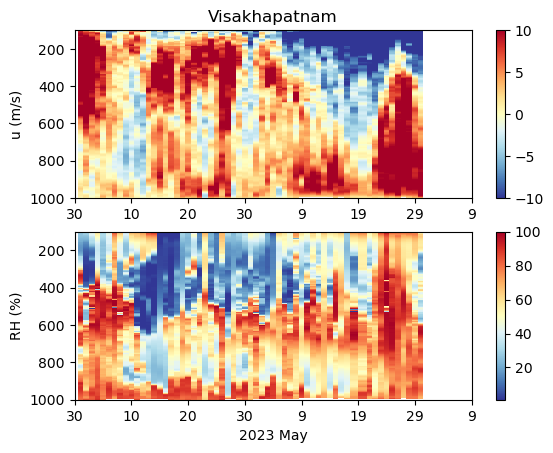

In [63]:
# do
# a big loop to read all sounding files, interpolate data to consistent levels
# output gridded files, and make plots

# reiterate parameters for paths, names, and gridding
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-5.0:0.0
CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
stationnames = lowercase.(CamelStations)

# allocate gridded data arrays (pressure, location, launch time)
nt = count_max_unique_soundings(stationnames)
# nt = 80 # allow for longest station mangalore?(37), extend & trim off extra later
times = zeros(DateTime, length(stationnames), nt)
T  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
Td = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
rh = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
z  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
u  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
v  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)

grid_imd_soundings!( times, T, Td, rh, z, u, v; plevs=plevs, stationnames=stationnames, reldatapath=reldatapath )

plot_timeheights( times, T, Td, rh, z, u, v )
write_new_grid_sondes( times, T, Td, rh, z, u, v; stationnames )

In [15]:
# tests

# count times at each station
nts = sum(times.>DateTime(1000), dims=2)
@show cat(CamelStations, nts, dims=2)


# test time-pressure plot at one station
sj = 1
@show size(u[:,sj,1:nts[sj]])

clf()
subplot(2,1,1)
# pcolormesh( times[sj,:], plevs, anom(T[:,sj,:],dims=2) )
# pcolormesh( times[sj,:], plevs, anom(th.(T[:,sj,:],plevs),dims=2), vmin=-7, vmax=7, cmap=ColorMap("RdYlBu_r") )
pcolormesh( times[sj,1:nts[sj]], plevs, u[:,sj,1:nts[sj]], vmin=-10, vmax=20, cmap=ColorMap("RdYlBu_r") )
ylim(1000, 100)
colorbar()
ylabel("u (m/s)")
title(CamelStations[sj])

subplot(2,1,2)
pcolormesh( times[sj,1:nts[sj]], plevs, rh[:,sj,1:nts[sj]], cmap=ColorMap("RdYlBu_r"))
ylim(1000, 100)
ylabel("RH (%)")
colorbar()

LoadError: MethodError: no method matching isless(::DateTime, ::typeof(time))
[0mClosest candidates are:
[0m  isless(::T, [91m::T[39m) where T<:TimeType at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Dates/src/types.jl:461
[0m  isless(::TimeType, [91m::TimeType[39m) at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Dates/src/types.jl:462
[0m  isless(::Any, [91m::PyCall.PyObject[39m) at ~/.julia/packages/PyCall/ilqDX/src/pyoperators.jl:76
[0m  ...